# Exercise sheet

Some general remarks about the exercises:
* For your convenience functions from the lecture are included below. Feel free to reuse them without copying to the exercise solution box.
* For each part of the exercise a solution box has been added, but you may insert additional boxes. Do not hesitate to add Markdown boxes for textual or LaTeX answers (via `Cell > Cell Type > Markdown`). But make sure to replace any part that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove the `raise NotImplementedError()`.
* Please make your code readable by humans (and not just by the Python interpreter): choose informative function and variable names and use consistent formatting. Feel free to check the [PEP 8 Style Guide for Python](https://www.python.org/dev/peps/pep-0008/) for the widely adopted coding conventions or [this guide for explanation](https://realpython.com/python-pep8/).
* Make sure that the full notebook runs without errors before submitting your work. This you can do by selecting `Kernel > Restart & Run All` in the jupyter menu.
* For some exercises test cases have been provided in a separate cell in the form of `assert` statements. When run, a successful test will give no output, whereas a failed test will display an error message.
* Each sheet has 100 points worth of exercises. Note that only the grades of sheets number 2, 4, 6, 8 count towards the course examination. Submitting sheets 1, 3, 5, 7 & 9 is voluntary and their grades are just for feedback.

Please fill in your name here:

In [1]:
NAME = "Kees van Kempen"
NAMES_OF_COLLABORATORS = "Bart Steeman" # We did not finish it together.

---

**Exercise sheet 6**

Code from the lecture

In [2]:
import numpy as np
import matplotlib.pylab as plt

rng = np.random.default_rng()
%matplotlib inline

def aligned_init_config(width):
    '''Produce an all +1 configuration.'''
    return np.ones((width,width),dtype=int)

def plot_ising(config,ax,title):
    '''Plot the configuration.'''
    ax.matshow(config, vmin=-1, vmax=1, cmap=plt.cm.binary)
    ax.title.set_text(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

from collections import deque

def neighboring_sites(s,w):
    '''Return the coordinates of the 4 sites adjacent to s on an w*w lattice.'''
    return [((s[0]+1)%w,s[1]),((s[0]-1)%w,s[1]),(s[0],(s[1]+1)%w),(s[0],(s[1]-1)%w)]

def cluster_flip(state,seed,p_add):
    '''Perform a single Wolff cluster move with specified seed on the state with parameter p_add.'''
    w = len(state)
    spin = state[seed]
    state[seed] = -spin  
    cluster_size = 1
    unvisited = deque([seed])   # use a deque to efficiently track the unvisited cluster sites
    while unvisited:   # while unvisited sites remain
        site = unvisited.pop()  # take one and remove from the unvisited list
        for nbr in neighboring_sites(site,w):
            if state[nbr] == spin and rng.uniform() < p_add:
                state[nbr] = -spin
                unvisited.appendleft(nbr)
                cluster_size += 1
    return cluster_size

def wolff_cluster_move(state,p_add):
    '''Perform a single Wolff cluster move on the state with addition probability p_add.'''
    seed = tuple(rng.integers(0,len(state),2))
    return cluster_flip(state,seed,p_add)

def compute_magnetization(config):
    '''Compute the magnetization M(s) of the state config.'''
    return np.sum(config)

def run_ising_wolff_mcmc(state,p_add,n):
    '''Run n Wolff moves on state and return total number of spins flipped.'''
    total = 0
    for _ in range(n):
        total += wolff_cluster_move(state,p_add)
    return total

def sample_autocovariance(x,tmax):
    '''Compute the autocorrelation of the time series x for t = 0,1,...,tmax-1.'''
    x_shifted = x - np.mean(x)
    return np.array([np.dot(x_shifted[:len(x)-t],x_shifted[t:])/len(x) 
                     for t in range(tmax)])

def find_correlation_time(autocov):
    '''Return the index of the first entry that is smaller than 
    autocov[0]/e or the length of autocov if none are smaller.'''
    smaller = np.where(autocov < np.exp(-1)*autocov[0])[0]
    return smaller[0] if len(smaller) > 0 else len(autocov)

## MCMC simulation of the XY model

**(100 Points)**

_Goal of this exercise_: Practice implementing MCMC simulation of the XY spin model using an appropriate cluster algorithm and analyzing the numerical effectiveness.

The **XY model** is a relative of the Ising model in which the discrete $\pm 1$ spin at each lattice site is replaced by a continuous $2$-dimensional spin on the unit circle 

$$
S_1 = \{(x,y)\in\mathbb{R}^2: x^2+y^2=1\}.
$$

To be precise, we consider a $w\times w$ lattice with periodic boundary conditions and a XY configuration $s = (s_1,\ldots,s_N) \in \Gamma = S_1^N$, $N=w^2$, with Hamiltonian that is very similar to the Ising model,

$$
H_{XY}(s) = - J \sum_{i\sim j} s_i \cdot s_j.
$$

Here, as in the Ising model, the sum runs over nearest neighbor pairs $i$ and $j$ and $s_i \cdot s_j$ is the usual Euclidean inner product of the vectors $s_i,s_j \in S_1$. We will only consider the ferromagnetic XY model and set $J=1$ in the remainder of the exercise. Note that nowhere in the definition the $x$- and $y$-components of the spins are related to the two directions of the lattice (one could also have studied the XY model on a one-dimensional or three-dimensional lattice and the spins would still have two components). As usual we are interested in sampling configurations $s\in \Gamma$ with distribution $\pi(s)$ given by the Boltzmann distribution

$$ 
\pi(s) = \frac{1}{Z_{XY}} e^{-\beta H_{XY}(s)}, \qquad \beta = 1/T.
$$

The XY model admits a (local) **cluster algorithm** that is very similar to the Wolff algorithm of the Ising model. It amounts to the following recipe:
1. Sample a uniform seed site $i_{\text{seed}}$ in $1,\ldots,N$ and an independent uniform unit vector $\hat{n} \in S_1$.
2. Grow a cluster $C$ starting from the seed $i_{\text{seed}}$ consisting only of sites $j$ whose spin $s_j$ is  "aligned" with the seed, in the sense that $s_j\cdot\hat{n}$ has the same sign as $s_{i_{\text{seed}}}\cdot \hat{n}$, or  $(s_j\cdot\hat{n})(s_{i_{\text{seed}}}\cdot \hat{n})>0$. Like in the Ising model this is done iteratively by examining the neighbors of sites that are already in the cluster, and adding those that are aligned with appropriate probability. The difference with the Ising model is that this probability depends on the spins $s_i$ and $s_j$ that are linked (meaning that $s_j$ is an aligned neighbor of $s_i$) via the formula
$$ p_{\text{add}}(s_i,s_j) = 1 - \exp\big( -2\beta\,(s_i\cdot\hat{n})(s_j\cdot\hat{n})\big).$$
3. Once the cluster $C$ is constructed, all of its spins are "flipped" in the sense that they are reflected in the plane perpendicular to $\hat{n}$, i.e. $s_j \to s_j - 2(s_j\cdot\hat{n})\hat{n}$.

__(a)__ Verify by a calculation, to be included using markdown and LaTeX below, that the probabilities $p_{\text{add}}(s_i,s_j)$ are the appropriate ones to ensure detailed balance for the Boltzmann distribution $\pi(s)$. _Hint_: Follow the same reasoning [as for the Ising model](https://hef.ru.nl/~tbudd/mct/lectures/cluster_algorithms.html#cluster-algorithm-for-the-ising-model-the-wolff-algorithm). Compare the probabilities involved in producing the cluster $C$ in state $s$ and state $s'$. Why do the probabilities only differ at the boundary edges in the cluster $C$? **(25 pts)**

The condition for detailed balance is $$\frac{P(s\rightarrow s')}{P(s'\rightarrow s)}=\frac{\pi(s')}{\pi(s)}.$$
Let's work to that expression by following the idea of the proof for the Ising model proof.

Starting from the left-hand side, consider the same cluster from the same seed and unit vector $\hat{n}$ but between different states $s$ and $s'$. Flipping between $s$ and $s'$ is done by the same cluster $C$, but from opposite sign. The probability of this happening is given by the boundaries of the clusters, namely that they are not added to the cluster, with probability $1 - p_{add}$ per boundary site. This gives a ratio $$\frac{P(s\rightarrow s')}{P(s'\rightarrow s)} = \frac{\prod_{<i,j>^+} (1-p_{add}(s_i, s_j))}{\prod_{<i,j>^-} (1-p_{add}(s_i, s_j))}$$ for pairs $<i,j>^\pm$ with $s_i \in C$ and $s_j$ neighbouring $s_i$ just outside the cluster with $\pm(s_i \cdot \hat{n})(s_j \cdot \hat{n}) > 0$. Substituting the formula for $p_{add}$ in, we find $$\frac{P(s\rightarrow s')}{P(s'\rightarrow s)} = \frac{\prod_{<i,j>^+} \exp(-2\beta(s_i \cdot \hat{n})(s_j \cdot \hat{n}))}{\prod_{<i,j>^-} \exp(2\beta(s_i \cdot \hat{n})(s_j \cdot \hat{n}))} = \prod_{<i,j>} \exp(-2\beta(s_i \cdot \hat{n})(s_j \cdot \hat{n})) = \exp(-2\beta\sum_{<i,j>} (s_i \cdot \hat{n})(s_j \cdot \hat{n}))$$ with $<i,j>$ describing both types of pairs.

For the right-hand side, $$\frac{\pi(s')}{\pi(s)} = e^{\beta \left[H_{XY}(s)-H_{XY}(s')\right]}$$ just from the definition of $\pi$.
This difference in energy we can write as
$$
H_{XY}(s)-H_{XY}(s') = \sum_{<i,j>} \left[ s_i \cdot s_j - s'_i \cdot s_j \right]
                     = 2\sum_{<i,j>} (s_i \cdot \hat{n})(s_j \cdot \hat{n})
$$
by summing over all pairs $<i,j>$ as above, as pairs not across the boundary do not give rise to an energy change. The last step is due to the flips from both signs to be accounted for.
This shows $$\frac{P(s\rightarrow s')}{P(s'\rightarrow s)}=\frac{\pi(s')}{\pi(s)},$$ thus that detailed balance holds.

__(b)__ In order to implement the cluster update described above, we take the state to be described by a Numpy array of dimension $(w,w,2)$, for which we have already provided a function `xy_aligned_init_config` to generate an all-aligned initial state. Write the function `xy_cluster_flip`, that grows and flips a cluster starting from the given seed site and $\hat{n}$ and returns the cluster size, and `xy_cluster_move`, that performs the previous function to a random seed and direction $\hat{n}$ and also returns the cluster size. **(20 pts)**

In [3]:
def xy_aligned_init_config(width):
    '''Return an array of dimension (width,width,2) representing aligned spins in x-direction.'''
    return np.dstack((np.ones((width,width)),np.zeros((width,width))))

def xy_cluster_flip(state,seed,nhat,beta):
    '''Perform a cluster move with specified seed and vector nhat on the state at temperature beta.'''
    w = len(state)
    
    # Let's flip along the way, starting with the seed.
    state[seed] -= 2*state[seed]@nhat*nhat
    # Use a double-ended queue to keep track of what elements to try to expand from.
    unvisited = deque([seed])
    cluster_size = 1
    while unvisited:
        site = unvisited.pop()
        # As the site is already added to the queue, it has already been flipped
        # so we need to take a minus into account.
        s_i_n = -state[site]@nhat
        for nbr in neighboring_sites(site,w):
            s_j_n = state[nbr]@nhat
            one_minus_p_add = np.exp(-2*beta*s_i_n*s_j_n)
            if np.sign(s_i_n) == np.sign(s_j_n) and rng.uniform() > one_minus_p_add:
                state[nbr] -= 2*s_j_n*nhat
                unvisited.appendleft(nbr)
                cluster_size += 1
    return cluster_size

def xy_cluster_move(state,beta):
    '''Perform a single Wolff cluster move on the state with addition probability p_add.'''
    seed = tuple(rng.integers(0,len(state),2))
    phi = 2*np.pi*rng.uniform()
    nhat = np.array([np.cos(phi), np.sin(phi)])
    return xy_cluster_flip(state,seed,nhat,beta)

In [4]:
from nose.tools import assert_almost_equal
assert 1 <= xy_cluster_flip(xy_aligned_init_config(4),(0,0),np.array([np.cos(0.5),np.sin(0.5)]),0.5) <= 16
assert_almost_equal(np.mean([xy_cluster_flip(xy_aligned_init_config(3),(0,0),
                                             np.array([np.cos(0.5),np.sin(0.5)]),0.3) 
                             for _ in range(200)]),5.3,delta=0.7)
assert_almost_equal(np.mean([xy_cluster_flip(xy_aligned_init_config(3),(1,2),
                                             np.array([np.cos(0.2),np.sin(0.2)]),0.2) 
                             for _ in range(200)]),4.3,delta=0.6)

In [5]:
assert 1 <= xy_cluster_move(xy_aligned_init_config(4),0.5) <= 16
assert_almost_equal(np.mean([xy_cluster_move(xy_aligned_init_config(3),0.3) 
                             for _ in range(200)]),3.6,delta=0.75)
assert_almost_equal(np.mean([xy_cluster_move(xy_aligned_init_config(3),0.9) 
                             for _ in range(200)]),6.3,delta=0.75)

__(c)__ Estimate and plot the average cluster size in equilibrium for a 25x25 lattice ($w=25$) for the range of temperatures $T = 0.5,0.6,\ldots,1.5$. It is not necessary first to estimate the equilibration time: you may start in a fully aligned state and use 400 moves for equilibration and 1000 for estimating the average cluster size. It is not necessary to estimate errors for this average. Store your averages in the data set `"cluster-size"` (an array of size 11) in the HDF5-file `xy_data.hdf5`, just like you did in Exercise sheet 5. Then read the data from file and produce a plot. **(20 pts)**

In [6]:
temperatures = np.linspace(0.5,1.5,11)
width = 25
equilibration_moves = 400
measurement_moves = 1000

import h5py
import time

t_0 = time.time()
def toc():
    """Return how many seconds the function was last called."""
    
    if not 't_0' in globals():
        return -np.inf
    
    global t_0
    dt = time.time() - t_0
    t_0 = time.time()
    return dt

with h5py.File("xy_data.hdf5", "a") as f:
    if not "cluster-size" in f:
        state = xy_aligned_init_config(width)
        cluster_sizes = np.zeros(len(temperatures))
        
        for idx, T in enumerate(temperatures):
            toc()
            print("T = {:.1f}".format(T))
            beta = 1/T
            
            # Equilibrate
            for _ in range(equilibration_moves):
                xy_cluster_move(state,beta)
            print("\tequilibrating took {:2.3f} seconds".format(toc()))
            
            # Measure
            for _ in range(measurement_moves):
                cluster_sizes[idx] += xy_cluster_move(state,beta)
            cluster_sizes[idx] /= measurement_moves
            print("\tmeasuring     took {:2.3f} seconds".format(toc()))
            print()
            
        f.create_dataset("cluster-size",data=cluster_sizes)

T = 0.5
	equilibrating took 5.3386430740356445  seconds
	measuring     took 13.652144193649292  seconds

T = 0.6
	equilibrating took 5.194417953491211  seconds
	measuring     took 12.401273727416992  seconds

T = 0.7
	equilibrating took 4.591171503067017  seconds
	measuring     took 11.19827151298523  seconds

T = 0.8
	equilibrating took 3.9237494468688965  seconds
	measuring     took 10.341700792312622  seconds

T = 0.9
	equilibrating took 3.6344528198242188  seconds
	measuring     took 9.163604021072388  seconds

T = 1.0
	equilibrating took 2.604698896408081  seconds
	measuring     took 6.472257137298584  seconds

T = 1.1
	equilibrating took 1.5426356792449951  seconds
	measuring     took 3.485330104827881  seconds

T = 1.2
	equilibrating took 0.4475827217102051  seconds
	measuring     took 1.3380379676818848  seconds

T = 1.3
	equilibrating took 0.294419527053833  seconds
	measuring     took 0.7950901985168457  seconds

T = 1.4
	equilibrating took 0.2504415512084961  seconds
	measur

In [7]:
with h5py.File('xy_data.hdf5','r') as f:
    assert f["cluster-size"][()].shape == (11,)
    assert_almost_equal(f["cluster-size"][4],225,delta=40)
    assert_almost_equal(f["cluster-size"][10],8,delta=8)

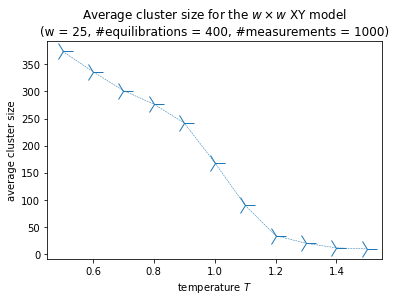

In [8]:
# Plotting
with h5py.File("xy_data.hdf5", "r") as f:
    plt.figure()
    # My girlfriend told me to use this marker.
    plt.plot(temperatures, np.array(f["cluster-size"]), marker="4", markersize=20, linestyle="dashed", linewidth=.5)
    plt.xlabel("temperature $T$")
    plt.ylabel("average cluster size")
    plt.title("Average cluster size for the $w \\times w$ XY model \n"
              "(w = {}, #equilibrations = {}, #measurements = {})"
              .format(width, equilibration_moves, measurement_moves))
    plt.show()

__(d)__ Make an MCMC estimate (and plot!) of the **mean square magnetization per spin** $\mathbb{E}[ m^2(s) ]$ for the same set of temperatures, where 

$$
m^2(s) = \left(\frac{1}{N}\sum_{i=1}^N s_i\right)\cdot\left(\frac{1}{N}\sum_{i=1}^N s_i\right).
$$

To choose the equilibration time and time between measurement, use the average cluster size from (c) to estimate how many moves correspond to 1 _sweep_, i.e. roughly $N = w^2$ updates to spins. Then use 100 equilibration _sweeps_ and 200 measurements of $m^2(s)$, with 2 _sweeps_ between each measurement. Store the measured values of $m^2(s)$ in the data set `"square-magn"` of dimension $(11,200)$ in `xy_data.hdf5`.
Then read the data and plot estimates for $\mathbb{E}[ m^2(s) ]$ including errors (based on batching or jackknife). If the errors are too small to see, you may multiply them by some number and indicate this in the title of the plot. **(20 pts)**

In [9]:
measurements = 200
equil_sweeps = 100
measure_sweeps = 2

with h5py.File("xy_data.hdf5", "a") as f:
    if not "square-magn" in f:
        state = xy_aligned_init_config(width)
        square_magn = np.zeros((len(temperatures), measurements))
        
        for idx, T in enumerate(temperatures):
            toc()
            print("T = {:.1f}".format(T))
            beta = 1/T
            # We let the sweep size depend on the width and the average cluster size
            # from before:
            sweep_size = np.ceil(width**2/f["cluster-size"][idx]).astype(int)
            
            # Equilibrate
            for j in range(equil_sweeps*sweep_size):
                xy_cluster_move(state,beta)
                print("\tequilibrating... [{}/{}]".format(j, equil_sweeps*sweep_size), end='\r')
            print("\tequilibrating took {:2.3f} seconds".format(toc()))
            
            # Measure
            for j in range(measurements):
                xy_cluster_move(state,beta)
                square_magn[idx][j] = np.linalg.norm(np.mean(state, axis=(0,1)))**2
                print("\tmeasuring... [{}/{}]".format(j, measurements), end='\r')
                
                # Sweeps between measurements
                # TODO: Skip sweeps between measurements for last measurement in set.
                for _ in range(measure_sweeps*sweep_size):
                    xy_cluster_move(state,beta)
            print("\tmeasuring     took {:2.3f} seconds".format(toc()))
            print()
            
        f.create_dataset("square-magn",data=square_magn)

T = 0.5
	equilibrating took 2.632 seconds
	measuring     took 13.054 seconds

T = 0.6
	equilibrating took 2.857 seconds
	measuring     took 12.967 seconds

T = 0.7
	equilibrating took 3.419 seconds
	measuring     took 16.536 seconds

T = 0.8
	equilibrating took 3.130 seconds
	measuring     took 14.666 seconds

T = 0.9
	equilibrating took 2.750 seconds
	measuring     took 12.164 seconds

T = 1.0
	equilibrating took 2.771 seconds
	measuring     took 11.674 seconds

T = 1.1
	equilibrating took 2.598 seconds
	measuring     took 9.313 seconds

T = 1.2
	equilibrating took 2.959 seconds
	measuring     took 10.833 seconds

T = 1.3
	equilibrating took 2.472 seconds
	measuring     took 9.212 seconds

T = 1.4
	equilibrating took 3.354 seconds
	measuring     took 10.768 seconds

T = 1.5
	equilibrating took 3.065 seconds
	measuring     took 9.898 seconds



In [10]:
with h5py.File('xy_data.hdf5','r') as f:
    assert f["square-magn"][()].shape == (11, 200)
    assert_almost_equal(np.mean(f["square-magn"][4]),0.456,delta=0.02)
    assert_almost_equal(np.mean(f["square-magn"][9]),0.023,delta=0.01)

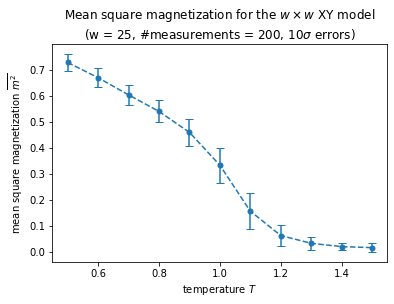

In [11]:
# Plotting

# As copied from last week:
def jackknife_batch_estimate(data,observable,k):
    '''Divide data into k batches and apply the function observable to each 
    collection of all but one batches. Returns the mean and corrected 
    standard error.'''
    batches = np.reshape(data,(k,-1))
    values = [observable(np.delete(batches,i,0).flatten()) for i in range(k)]
    return np.mean(values), np.sqrt(k-1)*np.std(values)

with h5py.File('xy_data.hdf5','r') as f:
    k = 100
    mean_sq, std_sq = np.array([jackknife_batch_estimate(data, np.mean, k) for data in f["square-magn"]]).T
    plt.figure()
    # I do plot a line to visualize the trend.
    plt.errorbar(temperatures, mean_sq, yerr=10*std_sq,
                 fmt='.--', markersize=10, capsize=4)
    plt.xlabel("temperature $T$")
    plt.ylabel("mean square magnetization $\\overline{m^2}$")
    plt.title("Mean square magnetization for the $w \\times w$ XY model \n"
              "(w = {}, #measurements = {}, $10\\sigma$ errors)"
              .format(width, measurements))
    plt.show()

__(e)__ Produce a single equilibrated state for each temperature and store them in the data set `"states"` of dimension $(11,25,25,2)$ in `xy_data.hdf5`. Then read them and produce a table of plots using the provided function `plot_xy`, which shows colors based on the angle of the spin, each with a title to indicate the temperature. Can you observe the [**Kosterlitz–Thouless transition** of the XY model](https://en.wikipedia.org/wiki/Classical_XY_model)? **(15 pts)**

In [12]:
width = 25
state = xy_aligned_init_config(width)
equil_sweeps = 200

with h5py.File("xy_data.hdf5", "a") as f:
    if not "states" in f:
        states = np.zeros(temperatures.shape + state.shape)
        for idx, T in enumerate(temperatures):
            toc()
            print("T = {:.1f}".format(T))
            beta = 1/T
            sweep_size = np.ceil(width**2/f["cluster-size"][idx]).astype(int)
            
            # Equilibrate
            for j in range(equil_sweeps*sweep_size):
                xy_cluster_move(state,beta)
                print("\tequilibrating... [{}/{}]".format(j, equil_sweeps*sweep_size), end='\r')
            print("\tequilibrating took {:2.3f} seconds".format(toc()))
            states[idx] = state.copy()
            print()
        
        f.create_dataset("states", data=states)

T = 0.5
	equilibrating took 5.540 seconds

T = 0.6
	equilibrating took 5.276 seconds

T = 0.7
	equilibrating took 6.958 seconds

T = 0.8
	equilibrating took 6.382 seconds

T = 0.9
	equilibrating took 5.454 seconds

T = 1.0
	equilibrating took 5.400 seconds

T = 1.1
	equilibrating took 4.564 seconds

T = 1.2
	equilibrating took 5.713 seconds

T = 1.3
	equilibrating took 5.184 seconds

T = 1.4
	equilibrating took 6.482 seconds

T = 1.5
	equilibrating took 6.137 seconds



In [13]:
with h5py.File('xy_data.hdf5','r') as f:
    assert f["states"][()].shape == (11, 25, 25, 2)

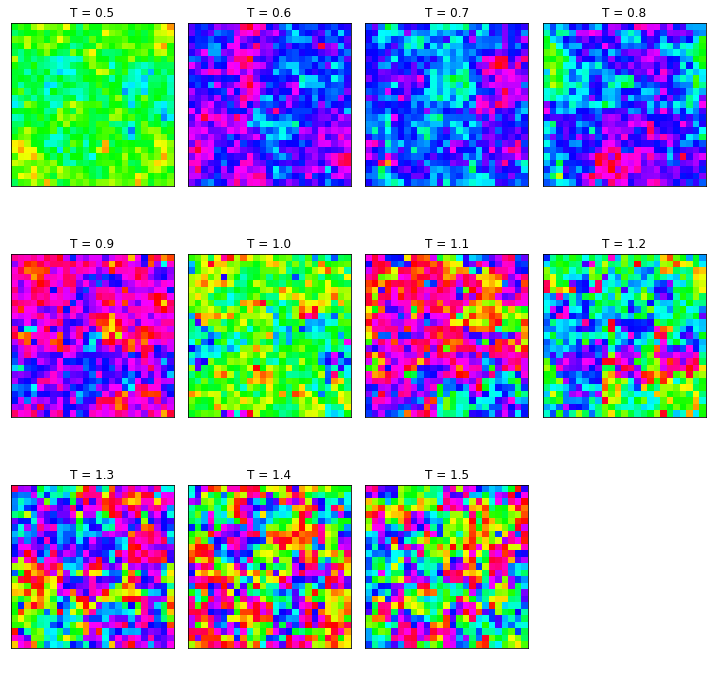

In [14]:
def plot_xy(state,ax,title=""):
    '''Plot the XY configuration given by state. Takes an Axes object ax from 
    matplotlib to draw to, and adds the specified title.'''
    angles = np.arctan2(*np.transpose(state,axes=(2,0,1)))
    ax.matshow(angles, vmin=-np.pi, vmax=np.pi, cmap=plt.cm.hsv)
    ax.title.set_text(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

# Make a table of plots
with h5py.File("xy_data.hdf5", "a") as f:
    fig, axs = plt.subplots(3, 4, figsize=(10, 10))
    axs = axs.ravel()
    for idx, T in enumerate(temperatures):
        plot_xy(f["states"][idx], axs[idx],"T = {:.1f}".format(T))
    
    # Hide the axes of unused plots.
    [ax.axis('off') for ax in axs[len(temperatures):]]
    plt.tight_layout()
    plt.show()

The Kosterlitz-Thouless transition is vaguely visible. For $T = 1.0$ and lower, vortices and anti-vortices can be recognized. Above this temperature, this structure vanishes.